In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import the top 5 models for each timeframe have been selected based on previous analysis
df_daily_1 = pd.read_csv('Results/LSTM/1D_GRID_LSTM/RUN2_DAILY_test_predictions_model_5.csv')
df_daily_2 = pd.read_csv('Results/LSTM/1D_GRID_LSTM/RUN2_DAILY_test_predictions_model_10.csv')
df_daily_3 = pd.read_csv('Results/LSTM/1D_GRID_LSTM/RUN1_DAILY_test_predictions_model_19.csv')
df_daily_4 = pd.read_csv('Results/LSTM/1D_GRID_LSTM/RUN1_DAILY_test_predictions_model_25.csv')
df_daily_5 = pd.read_csv('Results/LSTM/1D_GRID_LSTM/RUN2_DAILY_test_predictions_model_2.csv')

df_4h_1 = pd.read_csv('Results/LSTM/4H_GRID_LSTM/RUN4_4H_test_predictions_model_26.csv')
df_4h_2 = pd.read_csv('Results/LSTM/4H_GRID_LSTM/RUN4_4H_test_predictions_model_52.csv')
df_4h_3 = pd.read_csv('Results/LSTM/4H_GRID_LSTM/RUN3_4H_test_predictions_model_25.csv')
df_4h_4 = pd.read_csv('Results/LSTM/4H_GRID_LSTM/RUN3_4H_test_predictions_model_19.csv')
df_4h_5 = pd.read_csv('Results/LSTM/4H_GRID_LSTM/RUN3_4H_test_predictions_model_1.csv')

df_30min_1 = pd.read_csv('Results/LSTM/30MIN_GRID_LSTM/RUN(4)_30MIN_test_predictions_model_4.csv')
df_30min_2 = pd.read_csv('Results/LSTM/30MIN_GRID_LSTM/RUN(4)_30MIN_test_predictions_model_7.csv')
df_30min_3 = pd.read_csv('Results/LSTM/30MIN_GRID_LSTM/RUN(4)_30MIN_test_predictions_model_31.csv')
df_30min_4 = pd.read_csv('Results/LSTM/30MIN_GRID_LSTM/RUN(4)_30MIN_test_predictions_model_1.csv')
df_30min_5 = pd.read_csv('Results/LSTM/30MIN_GRID_LSTM/RUN(4)_30MIN_test_predictions_model_49.csv')

# These imports are solely for the "Actual" values for alignment purposes
df_4h_baseline = pd.read_csv('Results/LSTM/4H_GRID_LSTM/RUN1_4H_test_predictions_model_1.csv')
df_30min_baseline = pd.read_csv('Results/LSTM/30MIN_GRID_LSTM/RUN(1)_30MIN_test_predictions_model_4.csv')
df_daily_baseline = pd.read_csv('Results/LSTM/1D_GRID_LSTM/RUN1_DAILY_test_predictions_model_19.csv')

In [3]:
# Group models by timeframe
dfs_daily = [df_daily_1, df_daily_2, df_daily_3, df_daily_4, df_daily_5]
dfs_4h =[df_4h_1, df_4h_2, df_4h_3, df_4h_4, df_4h_5]
dfs_30min = [df_30min_1, df_30min_2, df_30min_3, df_30min_4, df_30min_5]

# Group all models
dfs = dfs_daily + dfs_4h + dfs_30min

# Rename prediction columns so all are consistent
for df in dfs:
    df.rename(columns={df.columns[1]: 'Predicted'}, inplace=True)


# The 4h and 30min need transforming back to their un-differenced values
# Update 'Actual' values for 4h DataFrames
for df in dfs_4h:
    df['Actual'] = df_4h_baseline['Actual']

# Update 'Actual' values for 30min DataFrames
for df in dfs_30min:
    df['Actual'] = df_30min_baseline['Actual']

# Adjust 'Predicted' values for all 4h DataFrames
for df in dfs_4h:
    df['Predicted'] = df['Actual'] + df['Predicted']

# Adjust 'Predicted' values for all 30min DataFrames
for df in dfs_30min:
    df['Predicted'] = df['Actual'] + df['Predicted']

In [4]:
# This function creates a new column, 'Shifted_Predicted', which represents what the model predicts for the value at t+1
def align_predictions(df):
    df['Shifted_Predicted'] = df['Predicted'].shift(-1)
    return df


# This functions calculates the percentage change forecast for t+1
def generate_comparison_metrics(df):
    df['Percent_Change_Forecast'] = ((df['Shifted_Predicted'] - df['Actual']) / df['Actual']) * 100
    return df


# Helper function to evaluate how the model performs when a trading strategy is simulated
def evaluate_performance(initial_cash, final_value):
    net_profit_loss = final_value - initial_cash
    roi = (final_value - initial_cash) / initial_cash * 100

    print(f"Initial Cash: ${initial_cash:.2f}")
    print(f"Final Portfolio Value: ${final_value:.2f}")
    print(f"Net Profit/Loss: ${net_profit_loss:.2f}")
    print(f"ROI: {roi:.2f}%")

    return net_profit_loss, roi


# Function to generate buy signals. Signal generated when the predicted value is greater than 'threshold_1'  
# percentage above the current value
def generate_buy_signals(df, threshold_1):
    df['Buy_Signal'] = df['Percent_Change_Forecast'] > threshold_1
    return df

# Function to generate sell signals. Signal generated when the predicted value is greater than (negative) 'threshold_2'  
# percentage below the current value
def generate_sell_signals(df, threshold_2):
    df['Sell_Signal'] = df['Percent_Change_Forecast'] < -threshold_2
    return df

In [48]:
def simulate_trading_strategy(df, initial_cash=10000):
    position = 0  # Current position (number of units held)
    cash = initial_cash
    trades = []  # Track trade history with detailed info
    buy_index = None  # Track index of buy to calculate trade duration

    # Loop through the DataFrame to simulate the strategy using the buy and sell signals
    for i in range(len(df) - 1):
        # Buy if a buy signal is present and no position is currently held
        if df['Buy_Signal'].iloc[i] and position == 0:
            buy_price = df['Actual'].iloc[i]
            position = cash / buy_price
            cash = 0
            buy_index = i
            trades.append({'Type': 'Buy', 'Index': i, 'Price': buy_price})

        # Sell if a sell signal is present and a position is currently held
        elif df['Sell_Signal'].iloc[i] and position > 0:
            sell_price = df['Actual'].iloc[i]
            cash = position * sell_price
            position = 0
            sell_index = i
            profit_loss = sell_price - trades[-1]['Price']
            duration = sell_index - buy_index  # Calculate duration of the trade
            trades.append({
                'Type': 'Sell',
                'Index': i,
                'Price': sell_price,
                'Profit/Loss': profit_loss,
                'Duration': duration
            })

    # Calculate the final portfolio value
    final_value = cash + position * df['Actual'].iloc[-1]

    # Convert trades to DataFrame
    trades_df = pd.DataFrame(trades)
    
    # Return the final value and the trades DataFrame
    return final_value, trades_df


def calculate_average_performance(results, timeframe):
    net_profits = []
    rois = []
    
    for model in results[timeframe].values():
        net_profits.append(model['net_profit_loss'])
        rois.append(model['roi'])
    
    avg_net_profit = np.mean(net_profits)
    avg_roi = np.mean(rois)
    
    print(f"Average Performance for {timeframe} models:")
    print(f"Average Net Profit: ${avg_net_profit:.2f}")
    print(f"Average ROI: {avg_roi:.2f}%")
    
    return {'average_net_profit': avg_net_profit, 'average_roi': avg_roi}


def calculate_total_trades(results, timeframe, model_key):
    trades_df = results[timeframe][model_key]['trades']
    total_trades = len(trades_df[trades_df['Type'] == 'Sell'])  # Count completed trades (pairs of Buy/Sell)

    return total_trades

    
def calculate_average_trade_length(results, timeframe, model_key):
    trades_df = results[timeframe][model_key]['trades']
    trade_durations = trades_df[trades_df['Type'] == 'Sell']['Duration']
    average_length = trade_durations.mean() if not trade_durations.empty else 0
    
    return average_length

In [6]:
def visualise_results_from_dictionary(results, baseline_actual, timeframe, model_key, xlim=None, ylim=None):
    # Extract trade data from the results dictionary
    trades_df = results[timeframe][model_key]['trades']
    
    # Plot the actual values from the baseline data
    plt.figure(figsize=(14, 6))
    plt.plot(baseline_actual, label='Actual Price', color='blue')
    
    # Mark buy and sell points using their indices from the trade data
    buy_points = trades_df[trades_df['Type'] == 'Buy']
    sell_points = trades_df[trades_df['Type'] == 'Sell']

    plt.scatter(buy_points['Index'], baseline_actual.iloc[buy_points['Index']], 
                marker='^', color='green', label='Buy Signal', s=100)
    plt.scatter(sell_points['Index'], baseline_actual.iloc[sell_points['Index']], 
                marker='v', color='red', label='Sell Signal', s=100)
    
    # Set title and labels
    plt.title(f'Trading Strategy: {model_key} ({timeframe})')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    
    # Set x and y limits if specified
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    
    # Display the plot
    plt.show()

In [28]:
# Initialise variables and dictionaries
initial_cash = 10000
threshold_1 = 0.5
threshold_2 = 0.5
results = {
    'daily': {},
    '4h': {},
    '30min': {}
}

# Process dataframes
for df in dfs:
    align_predictions(df)
    generate_comparison_metrics(df)
    generate_buy_signals(df, threshold_1)
    generate_sell_signals(df, threshold_2)

In [29]:
# Process daily models, print profit and ROI for each model, save results
for _, df in enumerate(dfs_daily, start=1):
    print(f"\nModel_{_}:")  # Print model label
    final_value, trades_df = simulate_trading_strategy(df, initial_cash)
    net_profit_loss, roi = evaluate_performance(initial_cash, final_value)
    
    results['daily'][f'model_{_}'] = {
        'final_value': final_value,
        'trades': trades_df,
        'net_profit_loss': net_profit_loss,
        'roi': roi
    }


Model_1:
Initial Cash: $10000.00
Final Portfolio Value: $27110.32
Net Profit/Loss: $17110.32
ROI: 171.10%

Model_2:
Initial Cash: $10000.00
Final Portfolio Value: $21575.60
Net Profit/Loss: $11575.60
ROI: 115.76%

Model_3:
Initial Cash: $10000.00
Final Portfolio Value: $24503.74
Net Profit/Loss: $14503.74
ROI: 145.04%

Model_4:
Initial Cash: $10000.00
Final Portfolio Value: $20749.64
Net Profit/Loss: $10749.64
ROI: 107.50%

Model_5:
Initial Cash: $10000.00
Final Portfolio Value: $23360.75
Net Profit/Loss: $13360.75
ROI: 133.61%


In [30]:
# Process 30min models, print profit and ROI for each model, save results
for _, df in enumerate(dfs_30min, start=1):
    print(f"\nModel_{_}:")  # Print model label
    final_value, trades_df = simulate_trading_strategy(df, initial_cash)
    net_profit_loss, roi = evaluate_performance(initial_cash, final_value)
    
    results['30min'][f'model_{_}'] = {
        'final_value': final_value,
        'trades': trades_df,
        'net_profit_loss': net_profit_loss,
        'roi': roi
    }


Model_1:
Initial Cash: $10000.00
Final Portfolio Value: $6669010.79
Net Profit/Loss: $6659010.79
ROI: 66590.11%

Model_2:
Initial Cash: $10000.00
Final Portfolio Value: $6323507.77
Net Profit/Loss: $6313507.77
ROI: 63135.08%

Model_3:
Initial Cash: $10000.00
Final Portfolio Value: $5147034.29
Net Profit/Loss: $5137034.29
ROI: 51370.34%

Model_4:
Initial Cash: $10000.00
Final Portfolio Value: $6104651.33
Net Profit/Loss: $6094651.33
ROI: 60946.51%

Model_5:
Initial Cash: $10000.00
Final Portfolio Value: $4973399.76
Net Profit/Loss: $4963399.76
ROI: 49634.00%


In [31]:
# Process 4h models, print profit and ROI for each model, save results
for _, df in enumerate(dfs_4h, start=1):
    print(f"\nModel_{_}:")  # Print model label
    final_value, trades_df = simulate_trading_strategy(df, initial_cash)
    net_profit_loss, roi = evaluate_performance(initial_cash, final_value)
    
    results['4h'][f'model_{_}'] = {
        'final_value': final_value,
        'trades': trades_df,
        'net_profit_loss': net_profit_loss,
        'roi': roi
    }


Model_1:
Initial Cash: $10000.00
Final Portfolio Value: $749125.18
Net Profit/Loss: $739125.18
ROI: 7391.25%

Model_2:
Initial Cash: $10000.00
Final Portfolio Value: $624483.12
Net Profit/Loss: $614483.12
ROI: 6144.83%

Model_3:
Initial Cash: $10000.00
Final Portfolio Value: $624391.54
Net Profit/Loss: $614391.54
ROI: 6143.92%

Model_4:
Initial Cash: $10000.00
Final Portfolio Value: $757384.32
Net Profit/Loss: $747384.32
ROI: 7473.84%

Model_5:
Initial Cash: $10000.00
Final Portfolio Value: $783524.00
Net Profit/Loss: $773524.00
ROI: 7735.24%


In [32]:
# Calculate average performances
avg_performance_4h = calculate_average_performance(results, '4h')
print('\n')
avg_performance_30min = calculate_average_performance(results, '30min')
print('\n')
avg_performance_daily = calculate_average_performance(results, 'daily')
print('\n')

Average Performance for 4h models:
Average Net Profit: $697781.63
Average ROI: 6977.82%


Average Performance for 30min models:
Average Net Profit: $5833520.79
Average ROI: 58335.21%


Average Performance for daily models:
Average Net Profit: $13460.01
Average ROI: 134.60%




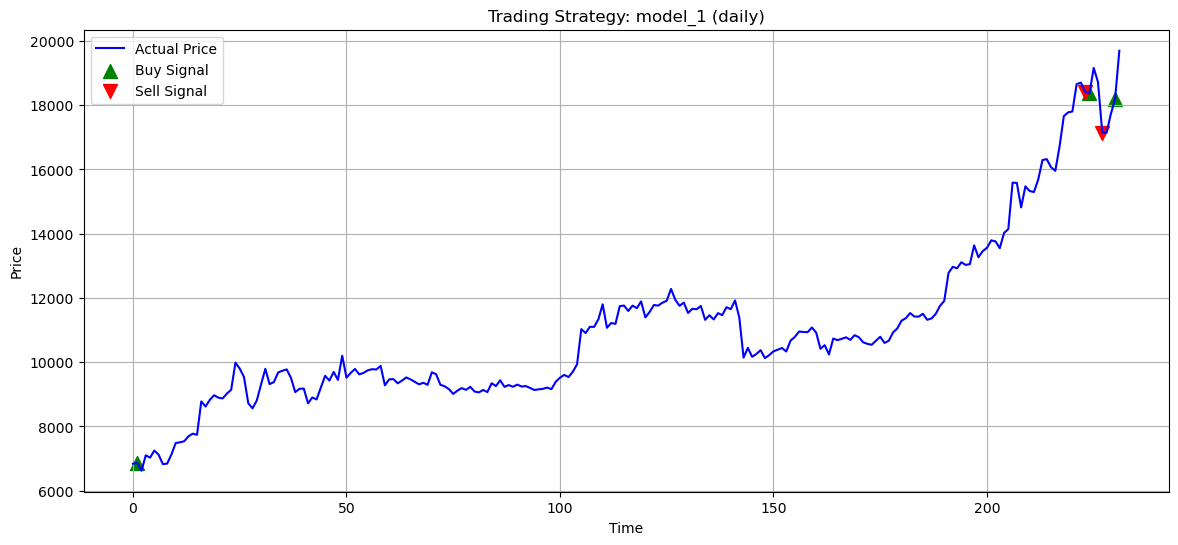

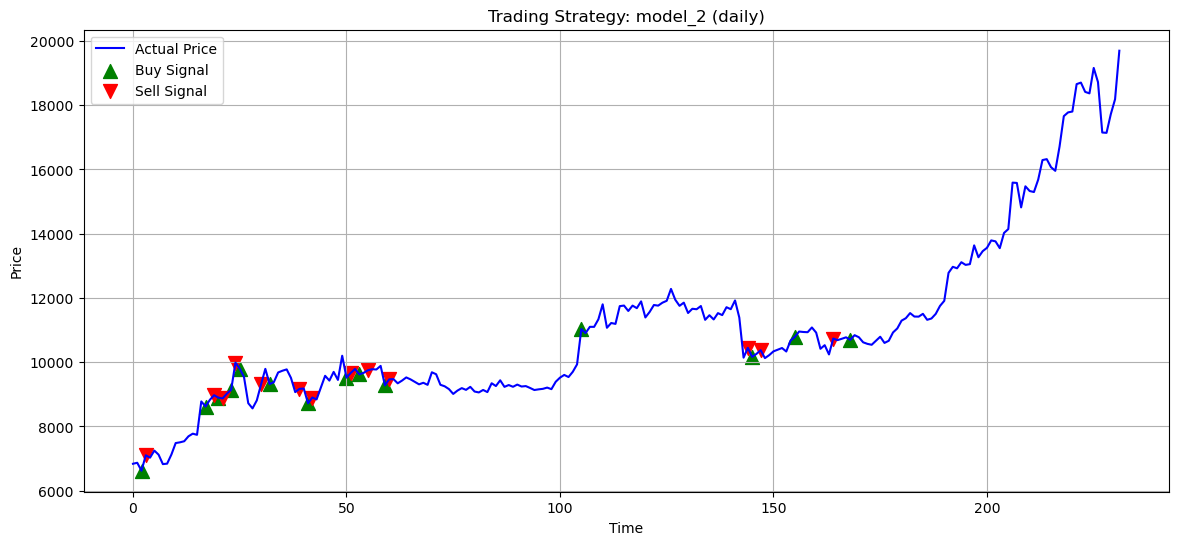

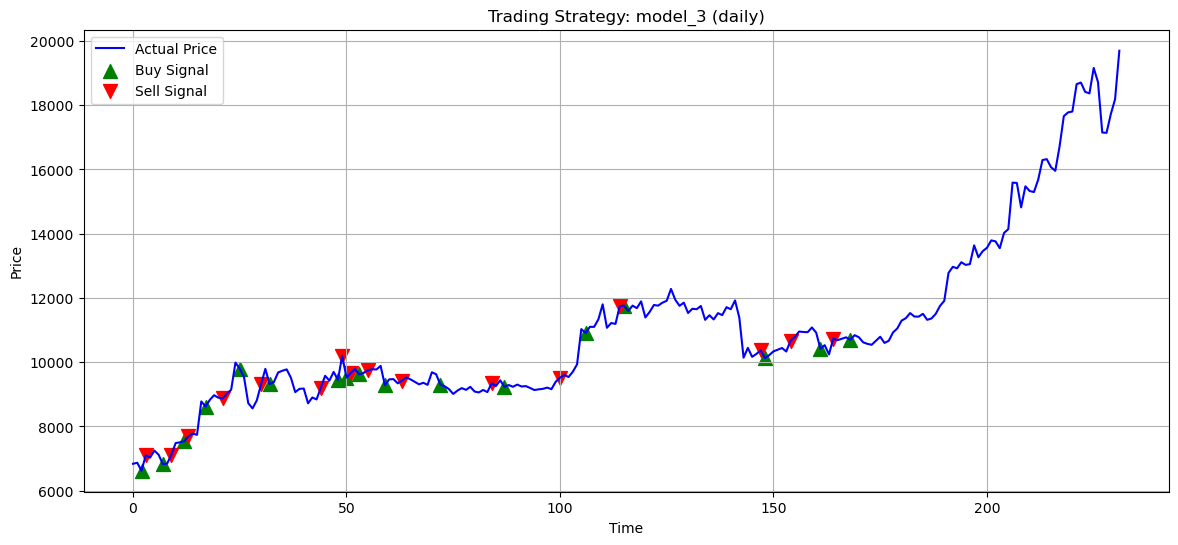

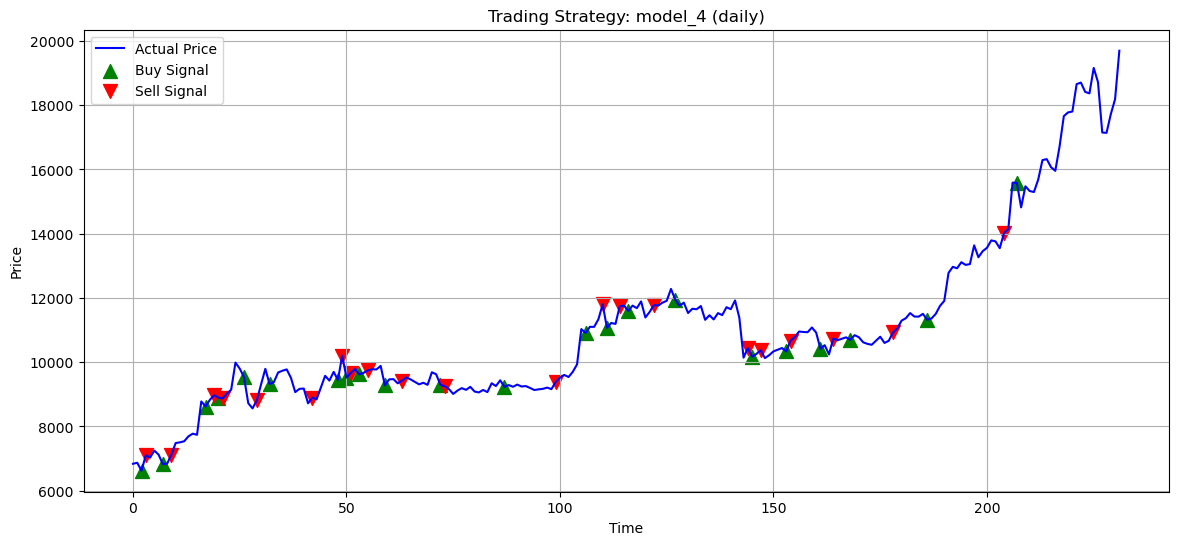

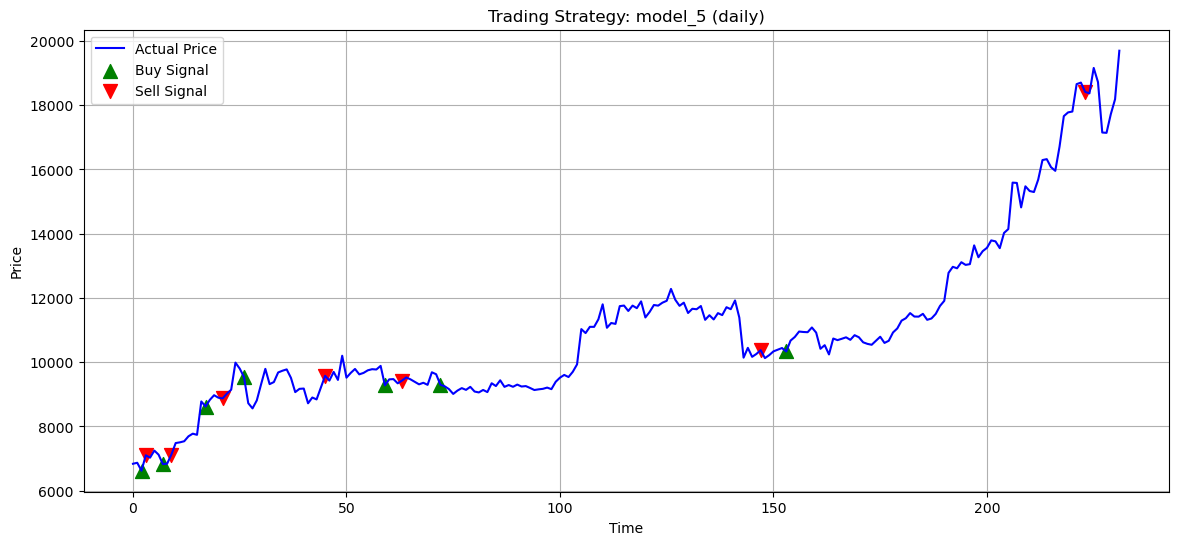

In [69]:
baseline_daily = df_daily_baseline['Actual']
x = 1
for df in dfs_daily:
    visualise_results_from_dictionary(results, baseline_daily, 'daily', f'model_{x}')
    x += 1

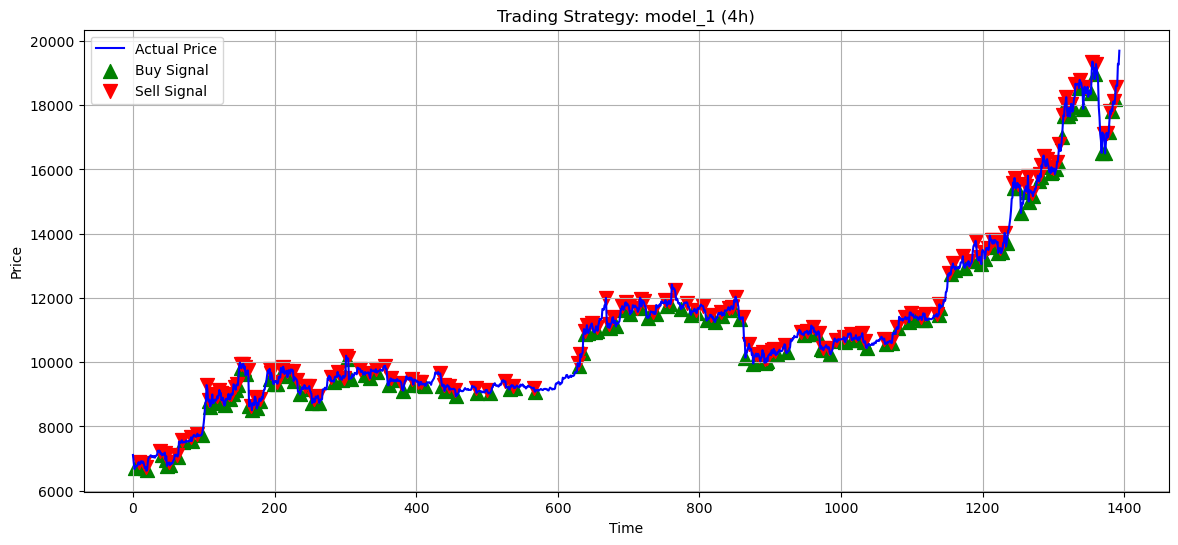

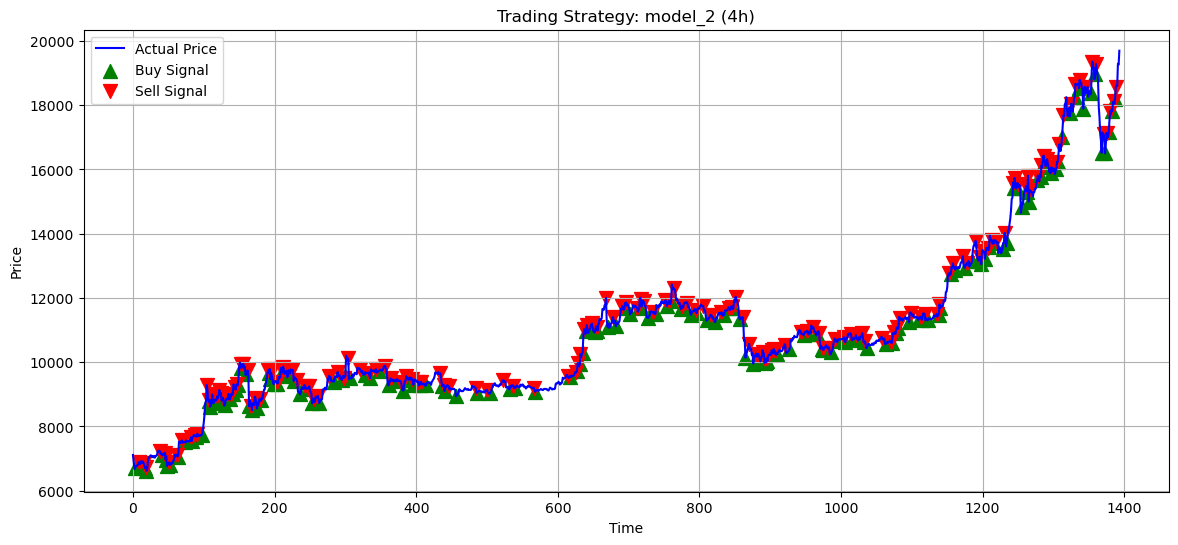

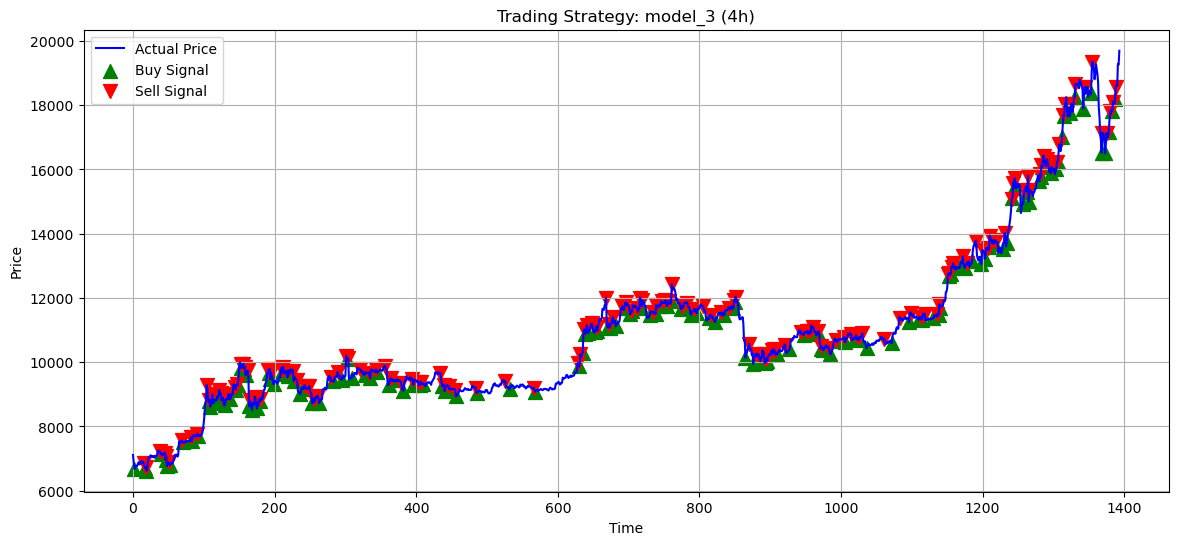

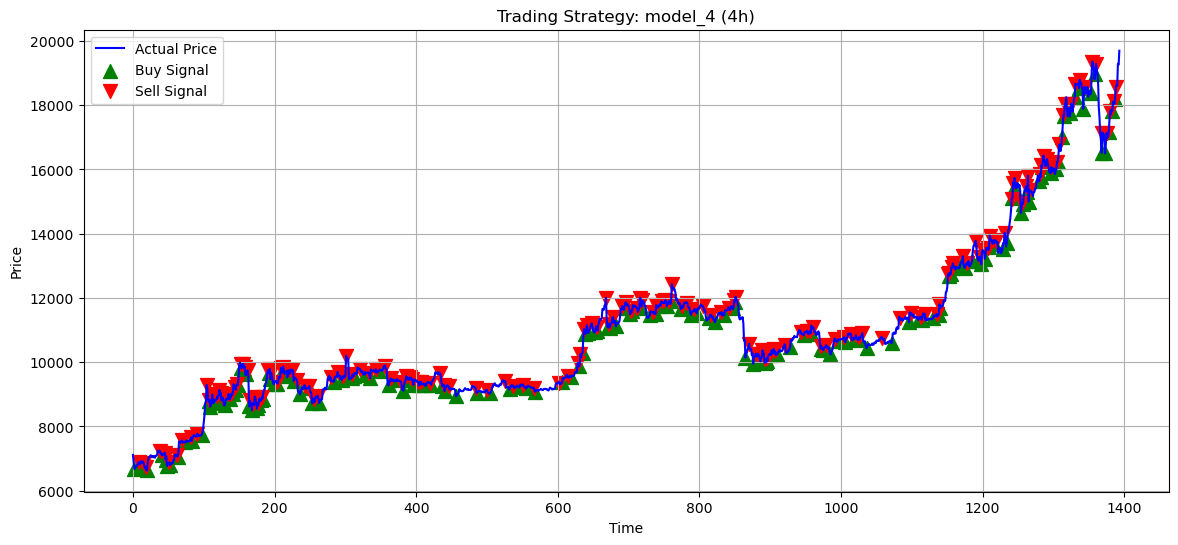

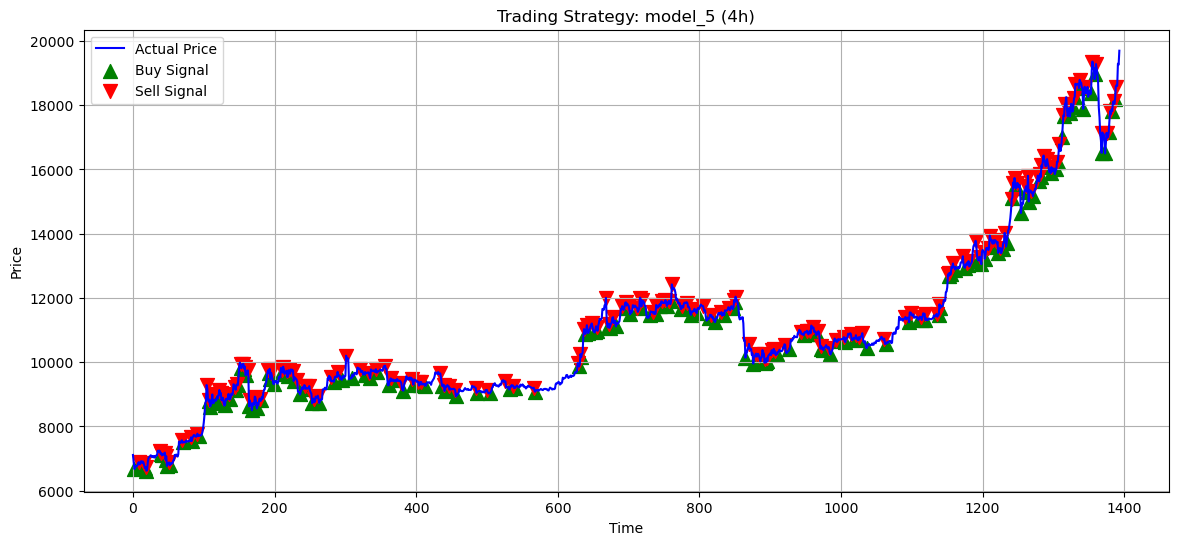

In [52]:
baseline_4h = df_4h_baseline['Actual']
x = 1
for df in dfs_4h:
    visualise_results_from_dictionary(results, baseline_4h, '4h', f'model_{x}')
    x += 1

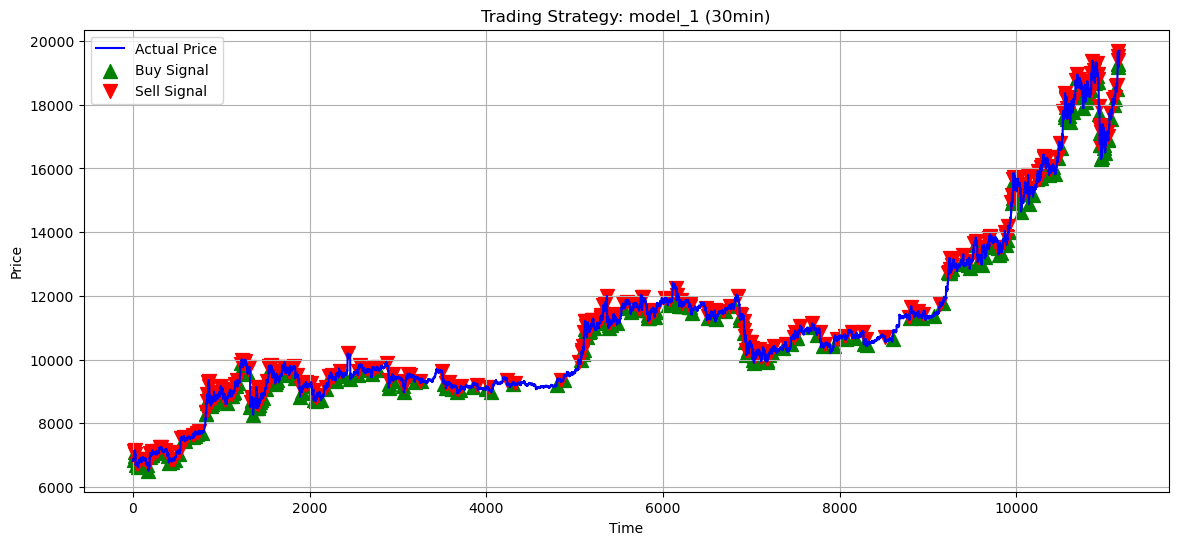

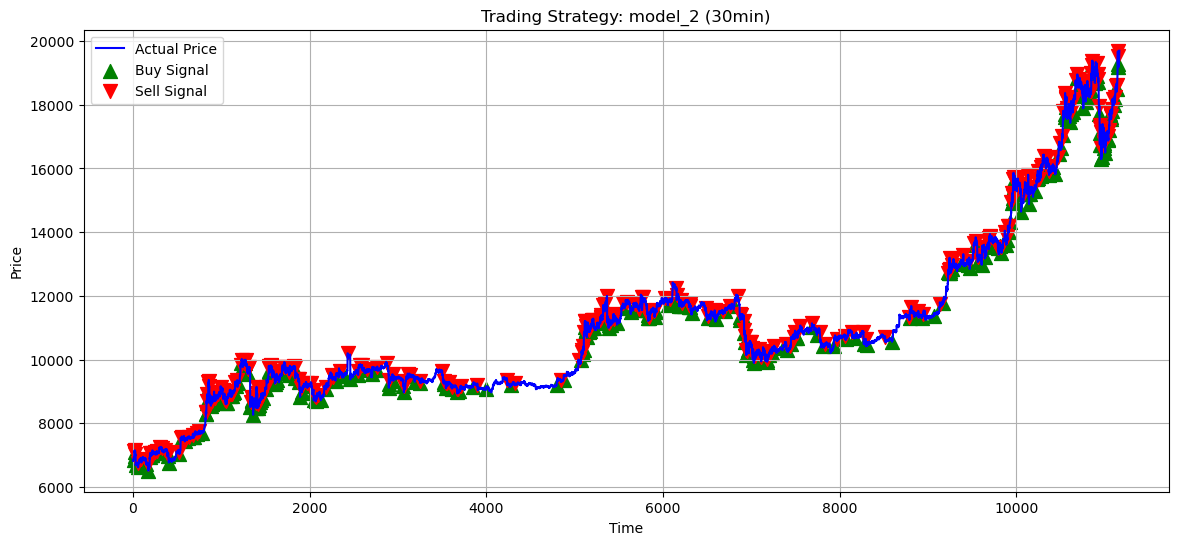

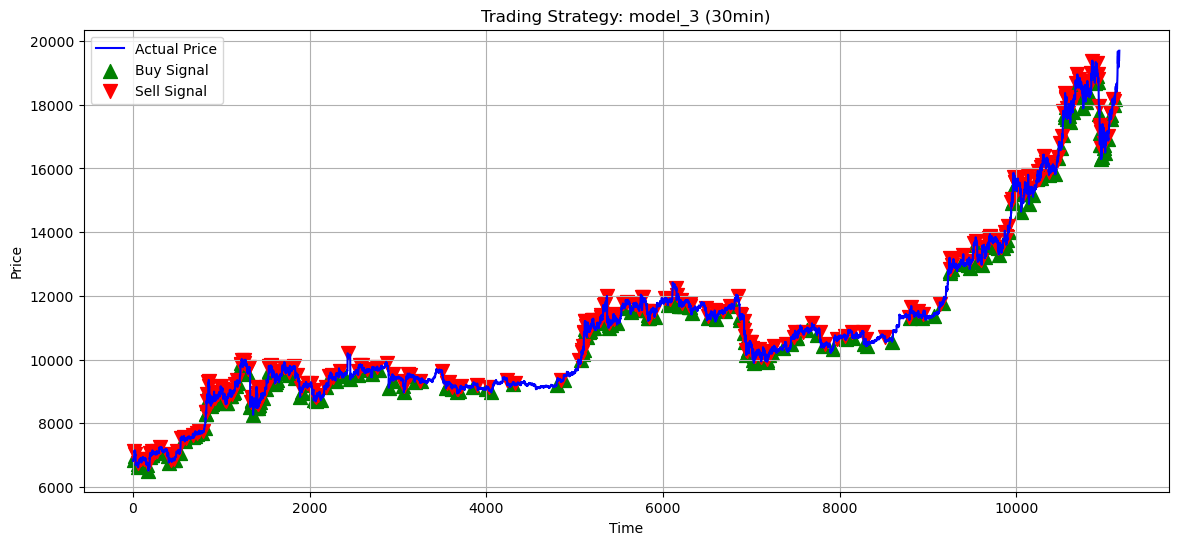

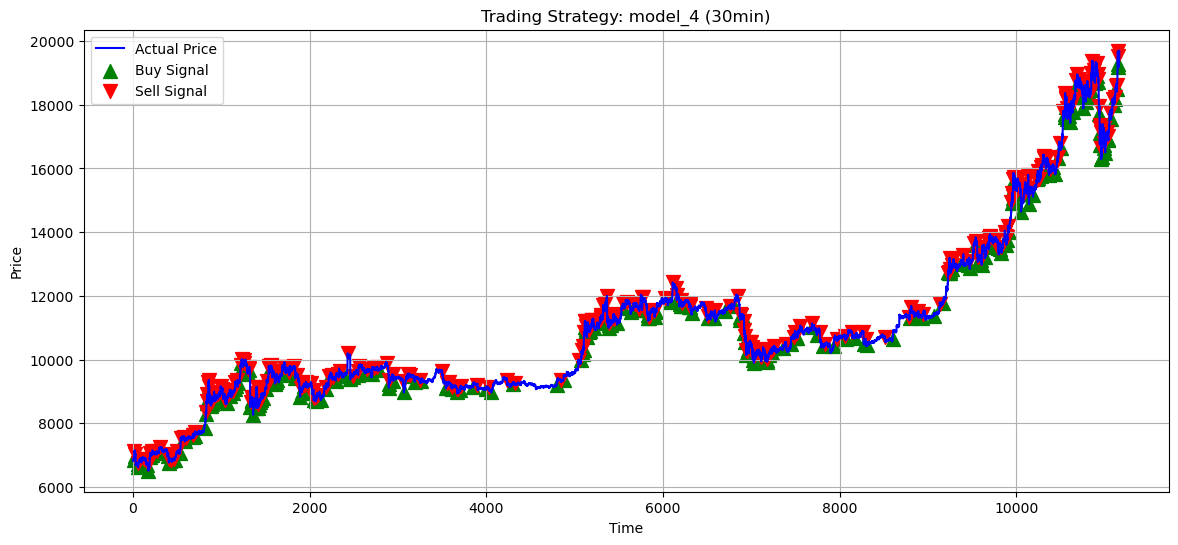

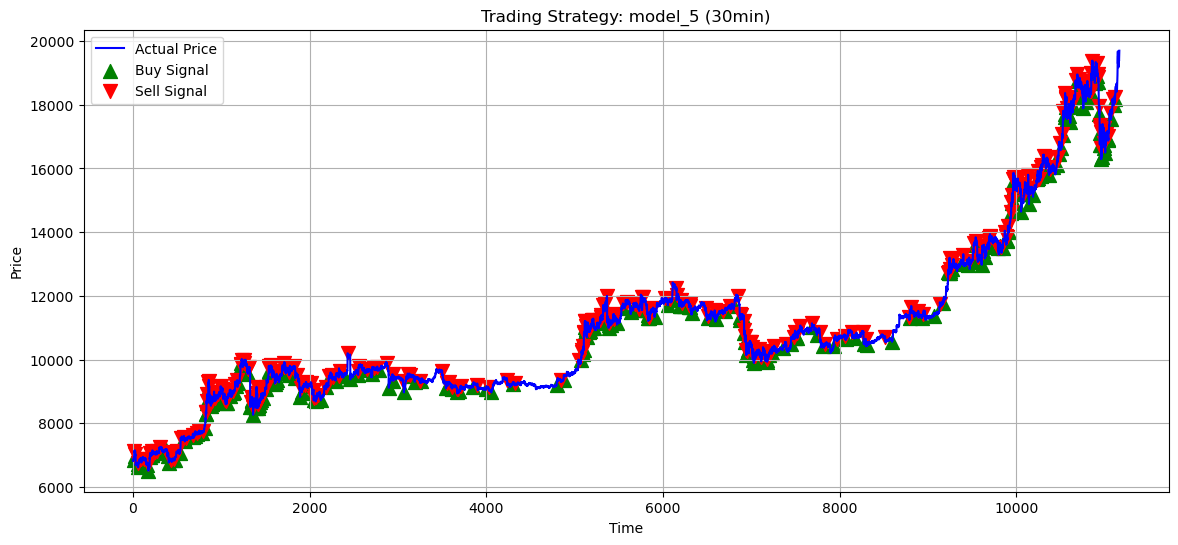

In [53]:
baseline_30min = df_30min_baseline['Actual']
x = 1
for df in dfs_30min:
    visualise_results_from_dictionary(results, baseline_30min, '30min', f'model_{x}')
    x += 1

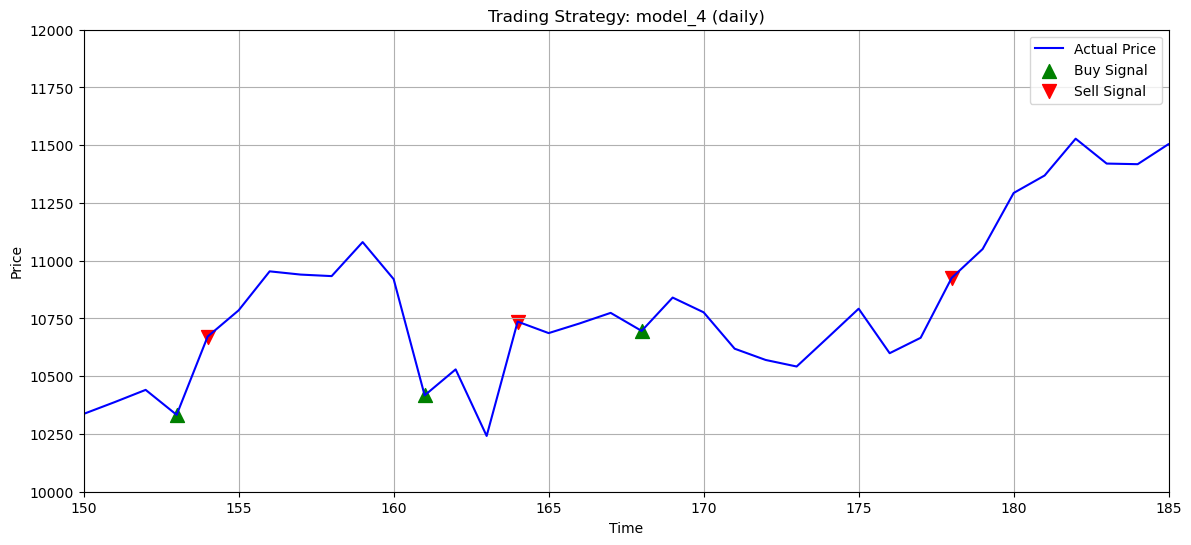

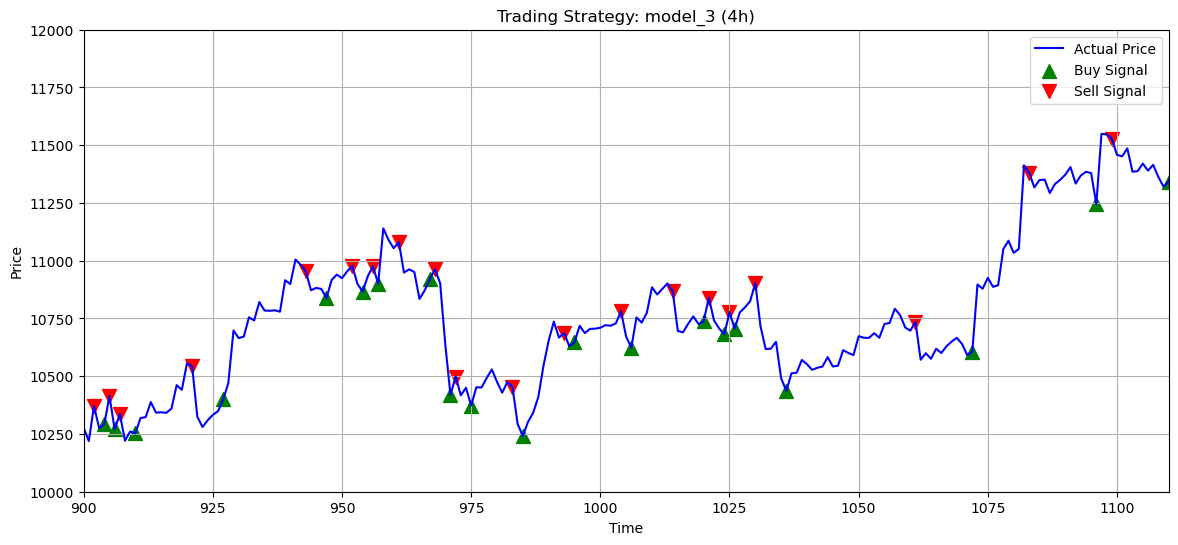

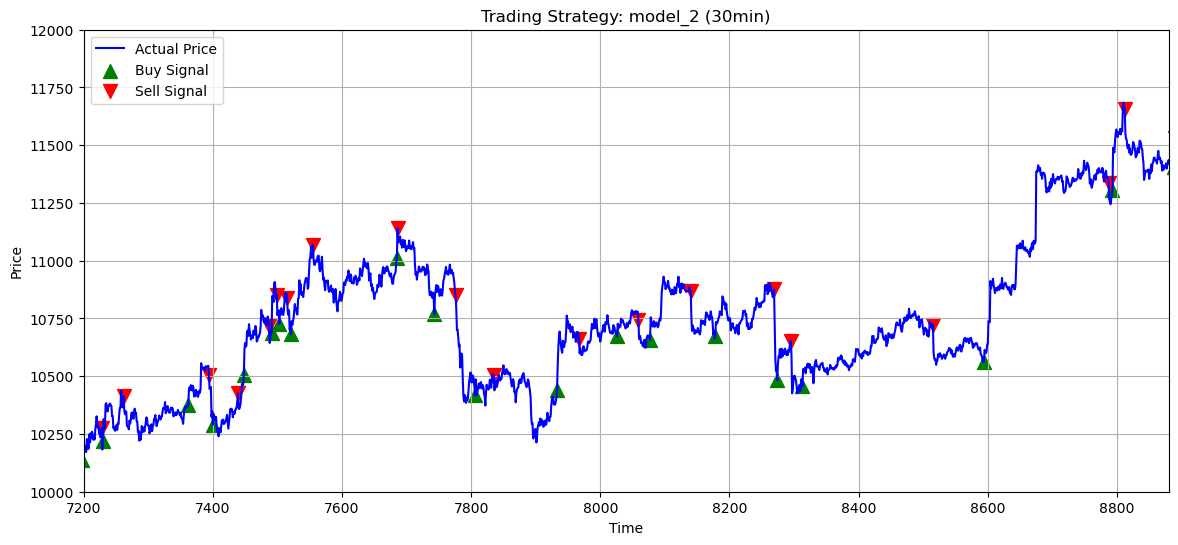

In [68]:
visualise_results_from_dictionary(results, baseline_daily, 'daily', 'model_4', xlim=(150, 185), ylim=(10000, 12000))
visualise_results_from_dictionary(results, baseline_4h, '4h', 'model_3', xlim=(900, 1110), ylim=(10000, 12000))
visualise_results_from_dictionary(results, baseline_30min, '30min', 'model_2', xlim=(7200, 8880), ylim=(10000, 12000))

In [50]:
def calculate_average_across_models(results, timeframe):
    model_keys = [f"model_{i}" for i in range(1, 6)]  # List of model keys: model_1, model_2, ..., model_5
    total_trades_list = []
    average_trade_length_list = []

    # Iterate over each model key and calculate the metrics
    for model_key in model_keys:
        total_trades = calculate_total_trades(results, timeframe, model_key)
        average_length = calculate_average_trade_length(results, timeframe, model_key)
        
        total_trades_list.append(total_trades)
        average_trade_length_list.append(average_length)

    # Calculate averages
    average_total_trades = sum(total_trades_list) / len(total_trades_list)
    average_trade_length = sum(average_trade_length_list) / len(average_trade_length_list)

    print(f"Average Total Trades across models for {timeframe}: {average_total_trades:.2f}")
    print(f"Average Trade Length across models for {timeframe}: {average_trade_length:.2f} periods")

    return average_total_trades, average_trade_length


In [51]:
average_trades, average_length = calculate_average_across_models(results, '30min')
print('\n')
average_trades, average_length = calculate_average_across_models(results, '4h')
print('\n')
average_trades, average_length = calculate_average_across_models(results, 'daily')


Average Total Trades across models for 30min: 336.60
Average Trade Length across models for 30min: 18.19 periods


Average Total Trades across models for 4h: 164.00
Average Trade Length across models for 4h: 5.28 periods


Average Total Trades across models for daily: 11.80
Average Trade Length across models for daily: 30.94 periods


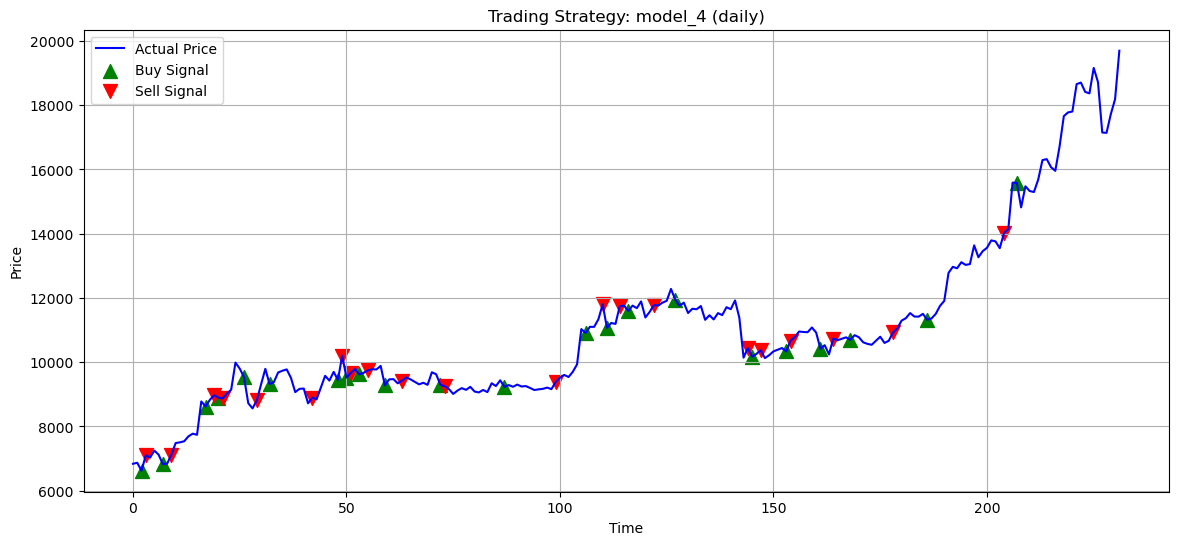

In [70]:
visualise_results_from_dictionary(results, baseline_daily, 'daily', 'model_4')

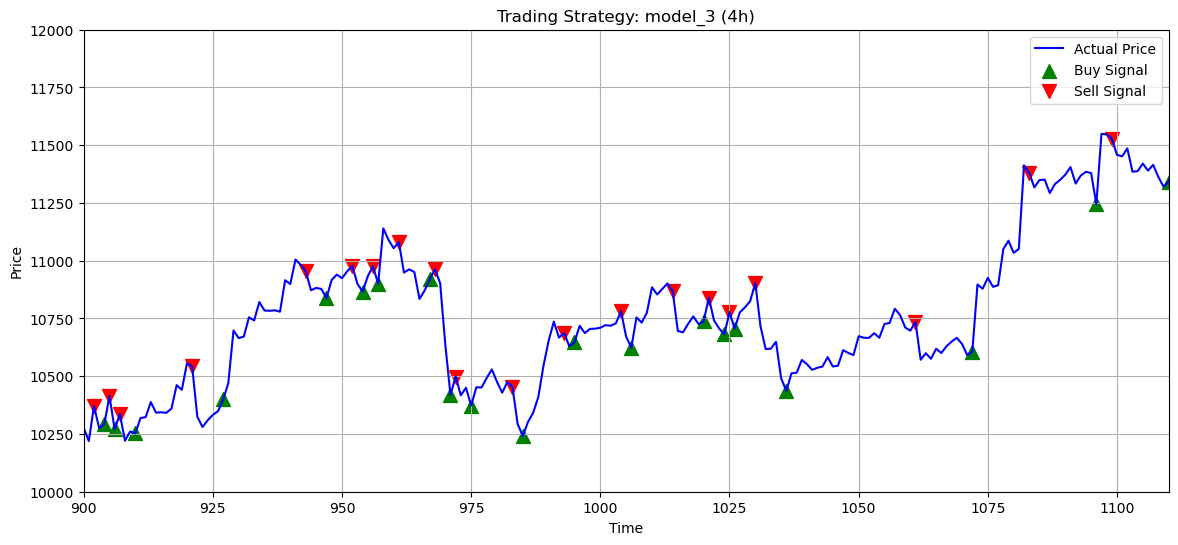

In [71]:
visualise_results_from_dictionary(results, baseline_4h, '4h', 'model_3', xlim=(900, 1110), ylim=(10000, 12000))